c:\Users\91623\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\91623\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
Gen. (-0.79) | Discrim. (0.08): 100%|██████████| 300/300 [00:13<00:00, 22.80it/s] 


JS Divergence (SMOTE): [0.06423682238003345, 0.06194483378037477, 0.047616206584004124, 0.05440741991161633, 0.0753908790569077, 0.03976231031866695, 0.08027233251251359, 0.012773753213912453, 0.0578252672903005]
JS Divergence (ADASYN): [0.0693737582301952, 0.06055324671220387, 0.04443333727162414, 0.04233070081284662, 0.08042050828465261, 0.03976231031866695, 0.08672244461046309, 0.012773753213912453, 0.0578252672903005]
JS Divergence (GAN): [0.11256947802182654, 0.08852700918553101, 0.2662061437812972, 0.12366488392014226, 0.17093531704348217, 0.18197793084476716, 0.13131597611727977, 0.4558053736549584, 0.5064914821930213]
KS Statistic (SMOTE): [0.14513343799058084, 0.15196232339089483, 0.17566718995290423, 0.0934850863422292, 0.14183673469387756, 0.13649921507064364, 0.1664050235478807, 0.07755102040816327, 0.08657770800627944]
KS Statistic (ADASYN): [0.1359497645211931, 0.12645211930926217, 0.17566718995290423, 0.0781789638932496, 0.13759811616954473, 0.13649921507064364, 0.162637

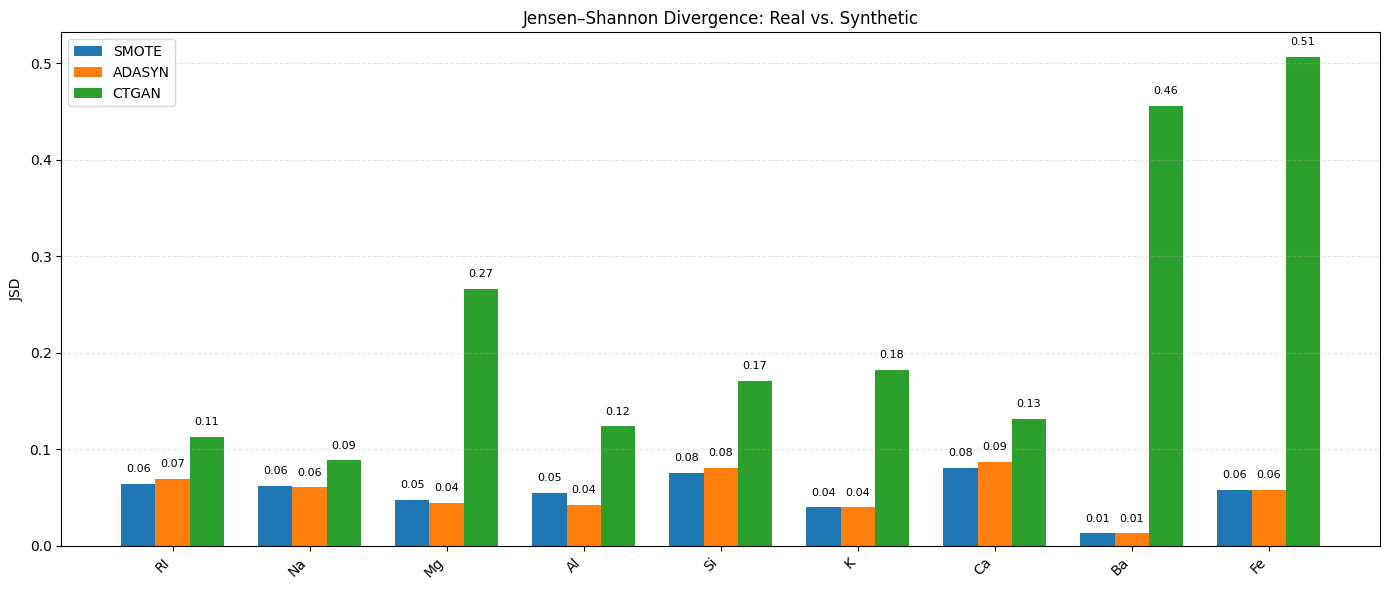

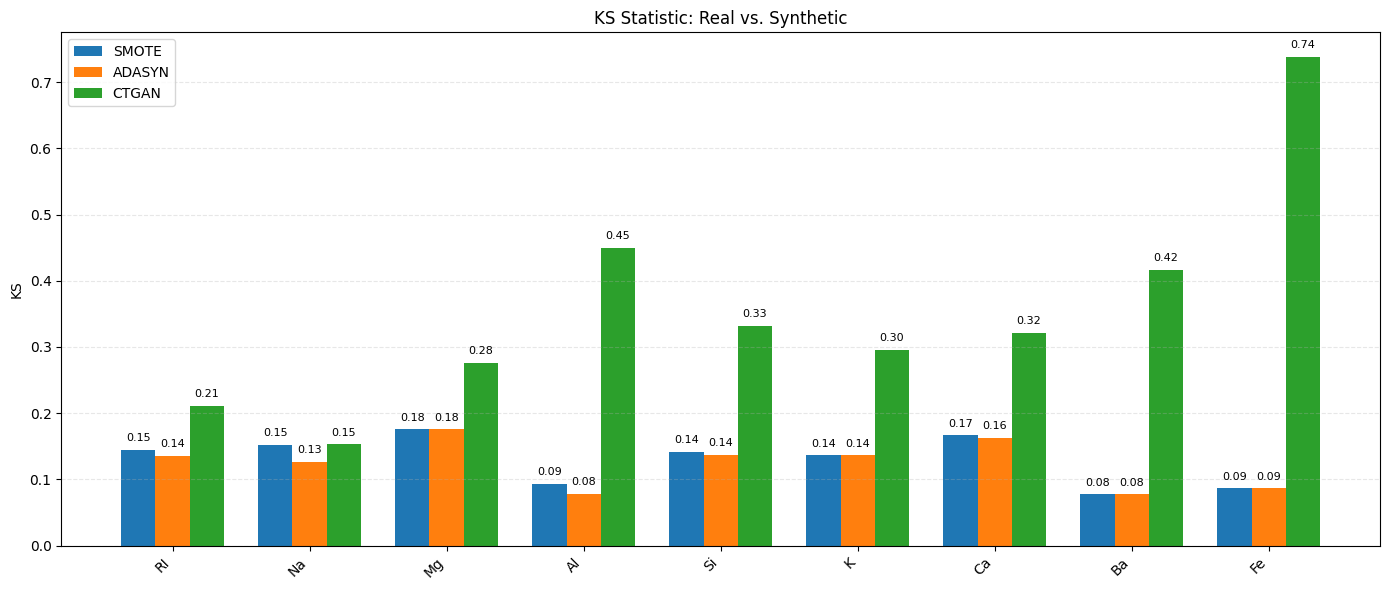

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, ADASYN
from ctgan import CTGAN
from scipy.stats import entropy, ks_2samp
import matplotlib.pyplot as plt

def jensen_shannon(p, q, eps=1e-12):
    """Compute JSD between two probability distributions."""
    p = p + eps; q = q + eps
    p /= p.sum(); q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

def compute_metrics(X_real, X_syn):
    """
    Compute per-feature Jensen–Shannon Divergence and KS statistic
    between real and synthetic datasets.
    Returns two lists: [jsd_per_feature], [ks_per_feature].
    """
    n_features = X_real.shape[1]
    jsd_list, ks_list = [], []
    for i in range(n_features):
        all_vals = np.concatenate([X_real[:, i], X_syn[:, i]])
        bins = np.histogram_bin_edges(all_vals, bins="auto")

        real_hist, _ = np.histogram(X_real[:, i], bins=bins, density=True)
        syn_hist, _  = np.histogram(X_syn[:, i], bins=bins, density=True)
        jsd_list.append(jensen_shannon(real_hist, syn_hist))

        ks_stat, _ = ks_2samp(X_real[:, i], X_syn[:, i])
        ks_list.append(ks_stat)

    return jsd_list, ks_list

def main():
    # 1. Load & preprocess data
    df = pd.read_csv("./glass.csv")
    for col in ("Id", "id"):
        if col in df.columns:
            df = df.drop(columns=[col])
    features = df.columns[:-1].tolist()
    X = df[features].values
    y = df["Type"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_eval, y_train, y_eval = train_test_split(
        X_scaled, y, stratify=y, test_size=0.3, random_state=42
    )

    # 2a. SMOTE (only minority classes)
    smote = SMOTE(sampling_strategy="minority", random_state=42)
    X_smote, _ = smote.fit_resample(X_train, y_train)

    # 2b. ADASYN (only minority classes)
    adasyn = ADASYN(sampling_strategy="minority", random_state=42)
    X_adasyn, _ = adasyn.fit_resample(X_train, y_train)

    # 2c. CTGAN
    df_train = pd.DataFrame(X_train, columns=features)
    df_train["Type"] = y_train
    ctgan = CTGAN(epochs=300, verbose=True)
    ctgan.fit(df_train, discrete_columns=["Type"])
    df_syn = ctgan.sample(len(df_train))
    X_ctgan = df_syn[features].values

    # 3. Compute metrics
    jsd_smote,   ks_smote   = compute_metrics(X_eval, X_smote)
    jsd_adasyn, ks_adasyn = compute_metrics(X_eval, X_adasyn)
    jsd_gan,     ks_gan     = compute_metrics(X_eval, X_ctgan)

    print("JS Divergence (SMOTE):", jsd_smote)
    print("JS Divergence (ADASYN):", jsd_adasyn)
    print("JS Divergence (GAN):", jsd_gan)
    print("KS Statistic (SMOTE):", ks_smote)
    print("KS Statistic (ADASYN):", ks_adasyn)
    print("KS Statistic (GAN):", ks_gan)

    # 4. Plot comparison
        # 4. Plot comparison (JSD and KS in separate charts with bar values)
    def plot_metric(values, title, ylabel, labels):
        x = np.arange(len(labels))
        width = 0.25

        plt.figure(figsize=(14, 6))
        bars1 = plt.bar(x - width, values[0], width, label="SMOTE")
        bars2 = plt.bar(x,         values[1], width, label="ADASYN")
        bars3 = plt.bar(x + width, values[2], width, label="CTGAN")

        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01,
                         f"{height:.2f}", ha="center", va="bottom", fontsize=8)

        plt.xticks(x, labels, rotation=45, ha="right")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Call plotting for JSD and KS
    plot_metric([jsd_smote, jsd_adasyn, jsd_gan],
                "Jensen–Shannon Divergence: Real vs. Synthetic",
                "JSD", features)

    plot_metric([ks_smote, ks_adasyn, ks_gan],
                "KS Statistic: Real vs. Synthetic",
                "KS", features)

        # Full datasets with synthetic labels (assumed same class distribution or minority-only)
    smote_full = pd.DataFrame(X_smote, columns=features)
    smote_full["Type"] = y_train[0]  # Placeholder if not preserved
    smote_full.to_csv("./full_smote_glass.csv", index=False)

    adasyn_full = pd.DataFrame(X_adasyn, columns=features)
    adasyn_full["Type"] = y_train[0]  # Adjust if needed
    adasyn_full.to_csv("./full_adasyn_glass.csv", index=False)

    ctgan_full = df_syn  # Already includes 'Type'
    ctgan_full.to_csv("./full_ctgan_glass.csv", index=False)


if __name__ == "__main__":
    main()
